# Explaining Models with Shap
- Daniel Barella 
- 2/25/23

## Load Your Saved Joblib File
- Create a new notebook for this assignment in your project 1 repository. Name the notebook "Explaining Models with Shap.ipynb"
- In your notebook, load the contents of your "best-models.joblib" file into a variable called "loaded_joblib."
- Save each object from the loaded_joblib dictionary as a separate variable in your notebook. (e.g. "X_train = loaded_joblib['X_train'])
## Explain your tree-based model with shap:
- Create an X_shap and y_shap variable from your training data (use shap.sample as needed).
- Create a model explainer,
- Calculate the shap values for your model.
- Create a summary plot - with plot_type='bar':
    - In a Markdown cell below, display your saved feature importance image (that you used in your README) and compare the most important features according to SHAP vs. your original feature importances.
        - Are they the same features in both? If not, what's different?
    - Save your bar summary plot figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
- Create a second summary plot - with plot_type='dot'
    - In a markdown cell, interpret the top 3 most important features and how they influence your model's predictions.
    - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
## Update your README.
- Insert your exported figures and corresponding interpretations from above into your README file. You should have:
    - a summary plot - bar version
        - Your comparison of most important features found by shap vs feature importance.
    - a summary plot - dot version
        - Your interpretation of the top 3 most important features and how they influence your model's predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'
## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics
## fixing random for lesson generation
SEED = 42
np.random.seed(SEED)

/var/folders/l7/w6kg6nmd3dgfd2wj06wwdb1c0000gn/T/ipykernel_54704/3539863356.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['fivethirtyeight','seaborn-talk'])


In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [3]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
import joblib
loaded_joblib = joblib.load('dec_tree_best-models.joblib')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'DecisionTreeRegressor'])

In [6]:
X_train_df = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test_df = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
loaded_model = loaded_joblib['DecisionTreeRegressor']

In [7]:
import shap
shap.initjs()

Training Data:	R^2= 0.60	RMSE= 1082.65
Test Data:	R^2= 0.59	RMSE= 1057.44


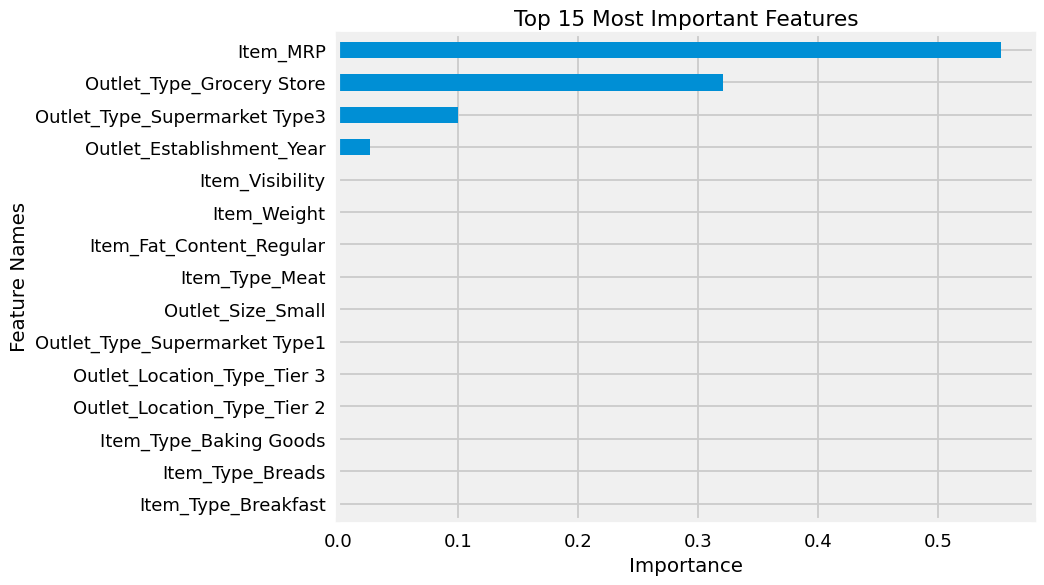

In [8]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_importances(loaded_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None);

In [9]:
len(X_train_df)


6392

In [10]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=SEED)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
2937    -1.076715        -0.512371  0.787847                  -1.293807   
6371    -0.761252        -0.696180  1.266775                   1.327849   
3762     1.030720        -1.291052 -1.667054                   0.017021   
419      1.445803        -0.760232 -0.233883                   1.089517   
8475     1.350927         0.285949 -0.789418                   0.136187   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
2937                       1.0                     0.0               0.0   
6371                       1.0                     0.0               0.0   
3762                       0.0                     0.0               0.0   
419                        0.0                     0.0               0.0   
8475                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
2937                  0.0               0.0              0.0   
6371                  0.0               0.0              0.0   
3762                  0.0               0.0              0.0   
419                   0.0               0.0              0.0   
8475                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
2937                     0.0                              1.0   
6371                     0.0                              0.0   
3762                     1.0                              0.0   
419                      0.0                              0.0   
8475                     0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
2937                    0.0                           0.0   
6371                    0.0                           0.0   
3762                    0.0                           0.0   
419                     0.0                           0.0   
8475                    0.0                           1.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
2937                  0.0             0.0               0.0   
6371                  0.0             0.0               0.0   
3762                  0.0             0.0               0.0   
419                   1.0             0.0               0.0   
8475                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_Type_Soft Drinks  \
2937                0.0                    0.0                    0.0   
6371                0.0                    1.0                    0.0   
3762                0.0                    0.0                    0.0   
419                 0.0                    0.0                    0.0   
8475                0.0                    0.0                    0.0   

      Item_Type_Starchy Foods  Outlet_Size_Large  Outlet_Size_MISSING  \
2937                      0.0                1.0                  0.0   
6371                      0.0                0.0                  0.0   
3762                      0.0                0.0                  1.0   
419                       0.0                0.0                  1.0   
8475                      0.0                0.0                  0.0   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
2937                 0.0                0.0                          0.0   
6371                 1.0                0.0                          0.0   
3762                 0.0                0.0                          0.0   
419                  0.0                0.0                          0.0   
8475                 1.0                0.0                          1.0   

      Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
2937                          0.0                          1.0   
6371                          0.0                          1.0   
3762                          0.0          

In [11]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

2937    2285.0256
6371    2217.1140
3762     196.4110
419     2940.1728
8475     378.1744
          ...    
5381    2841.6344
4918    3175.8660
1299    2960.1468
8096    1163.8184
2228     969.4048
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [12]:
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)

In [13]:
explainer = shap.Explainer(loaded_model)
explainer

In [14]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [15]:
X_shap.shape


(400, 32)

In [16]:
shap_values.shape


(400, 32)

In [17]:
shap_values

.values =
array([[ 5.45074089e-01,  4.68653634e-01,  7.24688250e+02, ...,
         0.00000000e+00,  0.00000000e+00, -1.92339418e+02],
       [ 5.45074089e-01,  4.68653634e-01,  1.23429889e+03, ...,
         0.00000000e+00,  0.00000000e+00, -1.57065947e+02],
       [-2.56560326e+00,  2.34923768e-01, -8.65080404e+02, ...,
         0.00000000e+00,  0.00000000e+00, -3.57566540e+01],
       ...,
       [ 9.51621015e+00,  1.99040732e+00,  2.23542119e+02, ...,
         0.00000000e+00,  0.00000000e+00, -1.49335819e+02],
       [-5.12696941e-01,  4.68653634e-01, -1.48540055e+03, ...,
         0.00000000e+00,  0.00000000e+00, -5.63024886e+01],
       [ 5.45074089e-01,  4.68653634e-01,  1.71831392e+03, ...,
         0.00000000e+00,  0.00000000e+00, -2.04655995e+02]])

.base_values =
array([[2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [2209.9793572],
       [22

In [18]:
pd.DataFrame(shap_values.values, columns = X_shap.columns)


Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
0       0.545074         0.468654   724.688250                 -27.779658   
1       0.545074         0.468654  1234.298892                 -27.779658   
2      -2.565603         0.234924  -865.080404                 -25.084032   
3      -0.512697         0.380402  -270.472826                 -99.690999   
4      -1.279493         0.468654  -764.754929                 -88.976840   
..           ...              ...          ...                        ...   
395     0.545074         0.380402  -271.001711                 -99.690999   
396     9.516210         0.468654   726.655142                 -27.779658   
397     9.516210         1.990407   223.542119                 -27.779658   
398    -0.512697         0.468654 -1485.400552                -107.715943   
399     0.545074         0.468654  1718.313925                 -27.779658   

     Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                    3.209832                     0.0               0.0   
1                    0.639813                     0.0               0.0   
2                   -1.826850                     0.0               0.0   
3                   -0.369892                     0.0               0.0   
4                   -0.369892                     0.0               0.0   
..                        ...                     ...               ...   
395                 -0.369892                     0.0               0.0   
396                 -0.369892                     0.0               0.0   
397                 -0.369892                     0.0               0.0   
398                  0.639813                     0.0               0.0   
399                  0.639813                     0.0               0.0   

     Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
0                    0.0               0.0              0.0   
1                    0.0               0.0              0.0   
2                    0.0               0.0              0.0   
3                    0.0               0.0              0.0   
4                    0.0               0.0              0.0   
..                   ...               ...              ...   
395                  0.0               0.0              0.0   
396                  0.0               0.0              0.0   
397                  0.0               0.0              0.0   
398                  0.0               0.0              0.0   
399                  0.0               0.0              0.0   

     Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
0                       0.0                              0.0   
1                       0.0                              0.0   
2                       0.0                              0.0   
3                       0.0                              0.0   
4                       0.0                              0.0   
..                      ...                              ...   
395                     0.0                              0.0   
396                     0.0                              0.0   
397                     0.0                              0.0   
398                     0.0                              0.0   
399                     0.0                              0.0   

     Item_Type_Hard Drinks  Item_Type_Health and Hygiene  Item_Type_Household  \
0                      0.0                           0.0                  0.0   
1                      0.0                           0.0                  0.0   
2                      0.0                           0.0                  0.0   
3                      0.0                           0.0                  0.0   
4                      0.0                           0.0                  0.0   
..                     ...                           ...                  ...   
395                    0.0                           0.0                  0.0   
396  

In [19]:
import os
os.makedirs("images/", exist_ok=True)

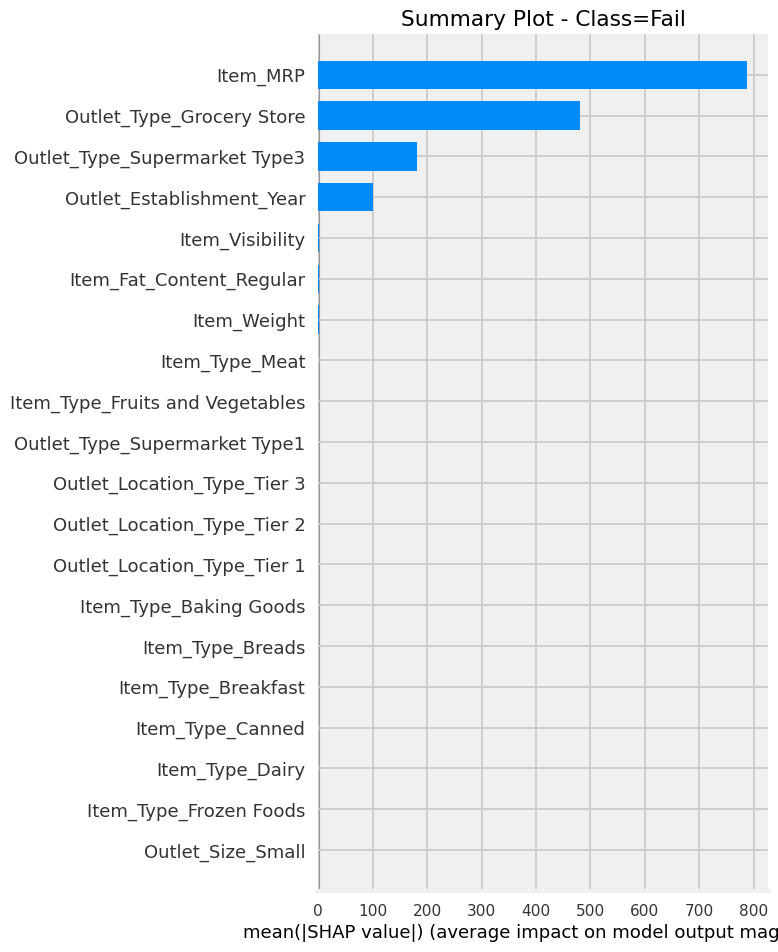

In [20]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, plot_type='bar', show=False)
ax.set_title('Summary Plot - Class=Fail');
fig.savefig('images/dec_tree_shap_bar.png')


![image](images/dec_tree.png)

-  The two graphs appear to be the same. No decernable differerences. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


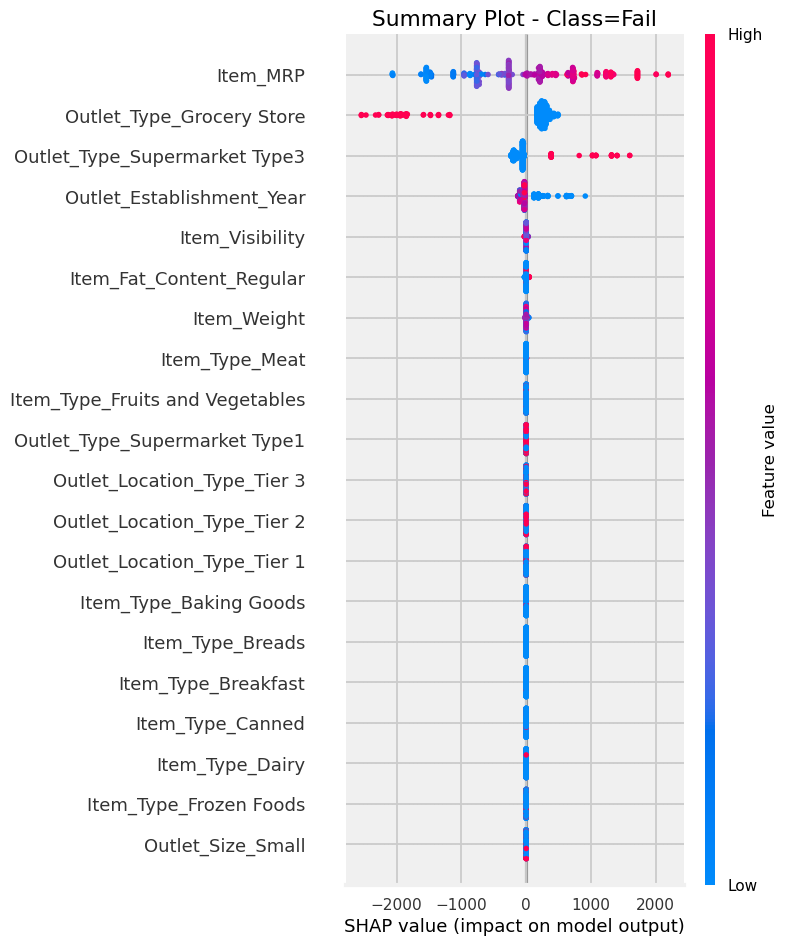

In [21]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, show=False)
ax.set_title('Summary Plot - Class=Fail');
fig.savefig('images/dec_tree_shap_dot.png')

- Item_MRP seems to be spread pretty evenly, in other words, this feature affects the target positively and negatively, and heavily since it's the top impactor.  
- Outlet_Type_Grocery Store	feature is much less likely to predict a fail.
-Outlet_Type_Supermarket Type3 is more likely to fail.


# Local Explanations


## Part 3 - Local Explanations
Continue working in your model explanation notebook from the previous core assignment. Add a new "Local Explanations" header at the bottom and continue your work:

- Select at least 2 example rows/outlets based on the insights gained from your previous core assignments this week.
- Explain why you selected the examples that you did.
    - If you're having trouble thinking of which type of examples to select, try selecting a store that had low sales ( one of the lowest values for your target) and one with high sales (the highest values for your target).
- For each example, produce :
    - a Lime tabular explanation
        - Interpret what features most heavily influenced the predictions, according to LIME.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: you will need to take a screenshot to save the lime explanation.
    - an Individual Force Plot
        - Interpret what features most heavily influenced the predictions, according to SHAP.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: you will need to take a screenshot to save the individual force plot.


### Update your README.
- Add your explanation for why you selected the individual examples that you visualized.
- For each example (need at least 2 examples)
    - A Lime tabular explanation
        - Your corresponding interpretation
    - A sharp force plot
        - Your corresponding interpretation.

In [22]:
y_shap.sort_values()

290       45.9402
170       47.9376
217       73.2380
365      105.8622
21       127.8336
          ...    
231     7943.6598
146     8262.5780
252     8474.3024
287     8474.3024
94     10256.6490
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [23]:
low_sales_store = y_shap.sort_values().iloc[0]
low_sales_store

45.9402

In [24]:
high_sales_store = y_shap.sort_values(ascending=False).iloc[0]
high_sales_store

10256.649

- I chose to go with the highest and lowest sales, to be able to see the contrast as to what features help the model make the decisions.

In [25]:
# Selecting a row
row = 290
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 290
- Target: 45.9402


Item_Weight                       -1.25
Item_Visibility                    3.12
Item_MRP                          -1.55
Outlet_Establishment_Year          0.02
Item_Fat_Content_Regular           1.00
Item_Type_Baking Goods             0.00
Item_Type_Breads                   0.00
Item_Type_Breakfast                0.00
Item_Type_Canned                   0.00
Item_Type_Dairy                    0.00
Item_Type_Frozen Foods             0.00
Item_Type_Fruits and Vegetables    0.00
Item_Type_Hard Drinks              0.00
Item_Type_Health and Hygiene       0.00
Item_Type_Household                0.00
Item_Type_Meat                     0.00
Item_Type_Others                   0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods              1.00
Item_Type_Soft Drinks              0.00
Item_Type_Starchy Foods            0.00
Outlet_Size_Large                  0.00
Outlet_Size_MISSING                1.00
Outlet_Size_Medium                 0.00
Outlet_Size_Small                  0.00


In [26]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

In [30]:
## Individual forceplot
low_sales_force_plot = shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row].values,
               features=X_shap.iloc[row],
# ADD matplotlib=True and show=False
                             matplotlib=True, show=False)
low_sales_force_plot.tight_layout()
plt.savefig('low_sales_force_plot.png')
low_sales_force_plot

- The low_sales_force_plot shows that there are no positive features, and at least two features that are affecting this store negatively.  



In [31]:
exp = lime_explainer.explain_instance(X_shap.iloc[row],
                               loaded_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


- The low_sales_lime_explanation, shows no positive features; and the Outlet_Type_Grocery Store, Item_MRP, Outlet_Type_Supermarket Type3, are greatly affecting this store negatively.	

In [32]:
# Selecting a row
row = 94
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 94
- Target: 10256.649


Item_Weight                        0.46
Item_Visibility                   -0.91
Item_MRP                           1.91
Outlet_Establishment_Year         -1.29
Item_Fat_Content_Regular           1.00
Item_Type_Baking Goods             0.00
Item_Type_Breads                   0.00
Item_Type_Breakfast                0.00
Item_Type_Canned                   0.00
Item_Type_Dairy                    1.00
Item_Type_Frozen Foods             0.00
Item_Type_Fruits and Vegetables    0.00
Item_Type_Hard Drinks              0.00
Item_Type_Health and Hygiene       0.00
Item_Type_Household                0.00
Item_Type_Meat                     0.00
Item_Type_Others                   0.00
Item_Type_Seafood                  0.00
Item_Type_Snack Foods              0.00
Item_Type_Soft Drinks              0.00
Item_Type_Starchy Foods            0.00
Outlet_Size_Large                  1.00
Outlet_Size_MISSING                0.00
Outlet_Size_Medium                 0.00
Outlet_Size_Small                  0.00


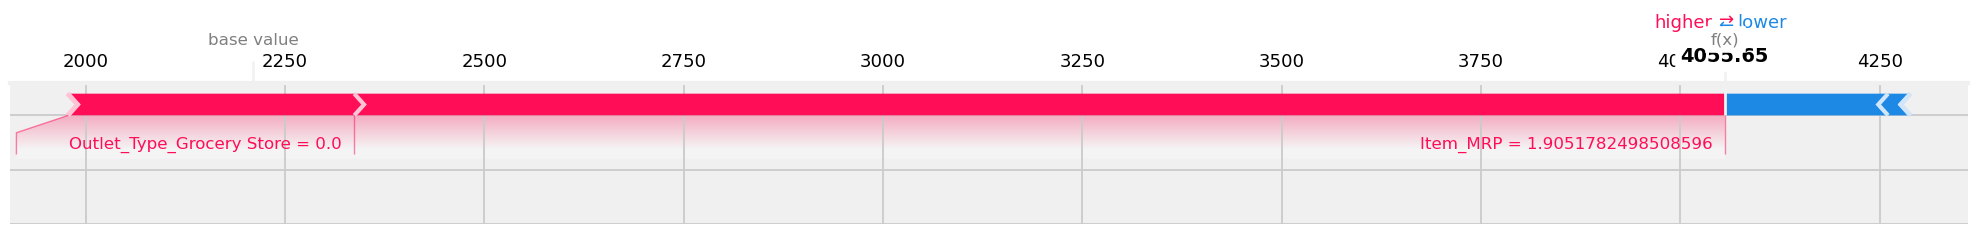

In [33]:
## Individual forceplot
high_sales_force_plot = shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row].values,
               features=X_shap.iloc[row],
# ADD matplotlib=True and show=False
                             matplotlib=True, show=False)
high_sales_force_plot.tight_layout()
plt.savefig('high_sales_force_plot.png')
high_sales_force_plot

- The high_sales_force_plot is showing that Outlet_Type_Grocery, Item_MRP, are greatly pushing this store into the positive.

In [34]:
exp = lime_explainer.explain_instance(X_shap.iloc[row],
                               loaded_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


- The high_sales_lime_explanation is showing once again that Outlet_Type_Grocery, Item_MRP, are the main features that can swing the sales numbers of a specific store.